# Distances

For this example notebook, we'll need to install Ripser.py to create the persistence diagrams:
```
pip install Cython ripser tadasets
```

In [1]:
import numpy as np
import persim
import tadasets
import ripser
import matplotlib.pyplot as plt

In [2]:
data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.1)

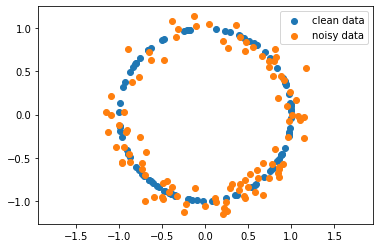

In [3]:
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data")
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data")
plt.axis('equal')
plt.legend()
plt.show()

## Generate $H_1$ diagrams for each of the data sets

In [4]:
dgm_clean = ripser.ripser(data_clean)['dgms'][1]
dgm_noisy = ripser.ripser(data_noisy)['dgms'][1]

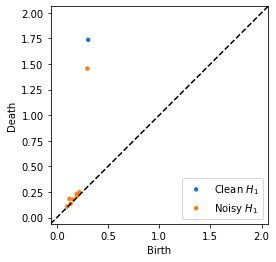

In [5]:
persim.plot_diagrams([dgm_clean, dgm_noisy] , labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.show()

## Compute and visualize Bottleneck distance

The `bottleneck` function has the option of returning the matching when the parameter `matching` is set to `True`. With the returned data, we can use the `plot.bottleneck_matching` function to visualize which persistence points contributed to the distance.  The bottleneck of the matching is shown as a red line, while the other pairs in the perfect matching which are less than the diagonal are shown as green lines (NOTE: There may be many possible matchings with the minimum bottleneck, and this returns an arbitrary one)

In [6]:
distance_bottleneck, matching = persim.bottleneck(dgm_clean, dgm_noisy, matching=True)

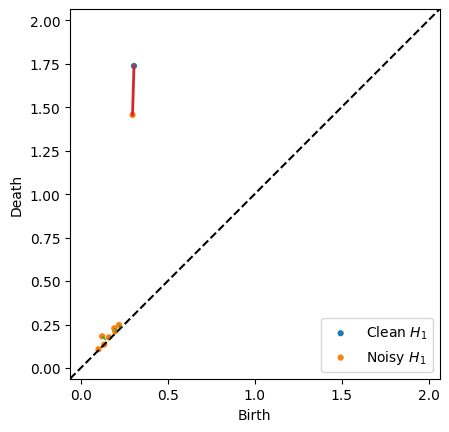

In [7]:
persim.bottleneck_matching(dgm_clean, dgm_noisy, matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.show()

The default option of `matching=False` will return just the distance if that is all you're interested in.

In [8]:
print(distance_bottleneck)
persim.bottleneck(dgm_clean, dgm_noisy)

0.2810312509536743


0.2810312509536743

Below is another example

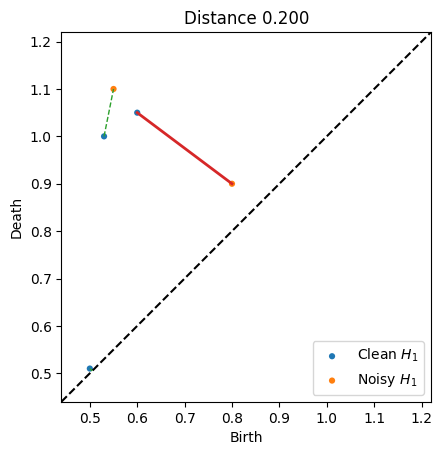

In [9]:
dgm1 = np.array([
    [0.6, 1.05],
    [0.53, 1],
    [0.5, 0.51]
])
dgm2 = np.array([
    [0.55, 1.1],
    [0.8,0.9]
])

d, matching = persim.bottleneck(
    dgm1,
    dgm2,
    matching=True
)

persim.bottleneck_matching(dgm1, dgm2, matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.title("Distance {:.3f}".format(d))
plt.show()

If we print the matching, we see that the diagram 1 point at index 0 gets matched to diagram 2's point at index 1, and vice versa.  The final row with 2, -1 indicates that diagram 1 point at index 2 was matched to the diagonal

In [10]:
matching

array([[ 0.   ,  1.   ,  0.2  ],
       [ 1.   ,  0.   ,  0.1  ],
       [ 2.   , -1.   ,  0.005]])

## Sliced Wasserstein distance


Sliced Wasserstein Kernels for persistence diagrams were introduced by [Carriere et al, 2017](https://arxiv.org/abs/1706.03358) and implemented by Alice Patania.

The general idea is to compute an approximation of the Wasserstein distance by computing the distance in 1-dimension repeatedly, and use the results as measure. To do so, the points of each persistence diagram are projected onto M lines that pass through (0,0) and forms an angle theta with the axis x.

In [11]:
persim.sliced_wasserstein(dgm_clean, dgm_noisy)

0.34984908615137117

The parameter `M` controls the number of iterations to run

In [12]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_clean, dgm_noisy, M=M) for M in Ms]

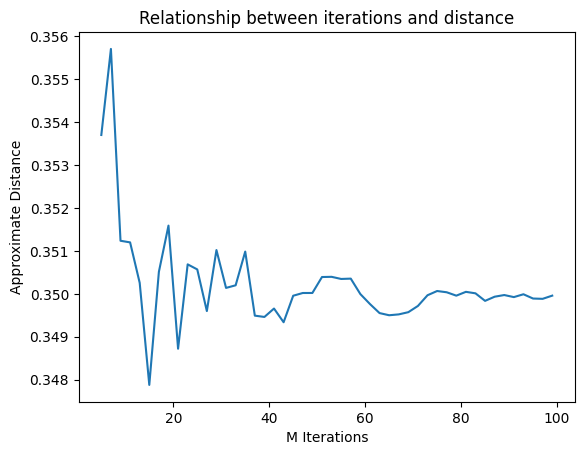

In [13]:
plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between iterations and distance")
plt.show()

## Heat Kernel Distance

We also implement the heat kernel distance

In [14]:
persim.heat(dgm_clean, dgm_noisy)

0.07119820450003951

The parameter `sigma` controls the heat diffusion.

In [15]:
sigmas = np.linspace(0.1, 10, 100)
ds = [persim.heat(dgm_clean, dgm_noisy, sigma=s) for s in sigmas]

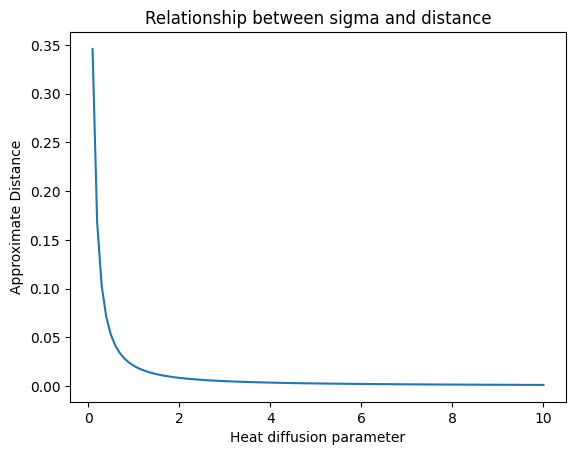

In [16]:
plt.plot(sigmas, ds)
plt.xlabel("Heat diffusion parameter")
plt.ylabel("Approximate Distance")
plt.title("Relationship between sigma and distance")
plt.show()

## Various levels of noise

In this example, we will simulate various levels of noise and compute the distances from the clean circle

In [17]:
data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
dgm_clean = ripser.ripser(data_clean)['dgms'][1]

In [18]:
dists = []
noise_levels = np.linspace(0.0, 0.9, 30)
samples = 15

dists_bottleneck=[]
dists_sliced=[]

for n in noise_levels:
    for i in range(samples):
        ds_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
        dgm_clean = ripser.ripser(ds_clean)['dgms'][1]
        
        ds = tadasets.dsphere(d=1, n=100, noise=n)
        dgm = ripser.ripser(ds)['dgms'][1]
        
        dists_bottleneck.append((n, persim.bottleneck(dgm_clean, dgm)))
        dists_sliced.append((n, persim.sliced_wasserstein(dgm_clean, dgm))) 
        
dists_sliced = np.array(dists_sliced)
dists_bottleneck = np.array(dists_bottleneck)

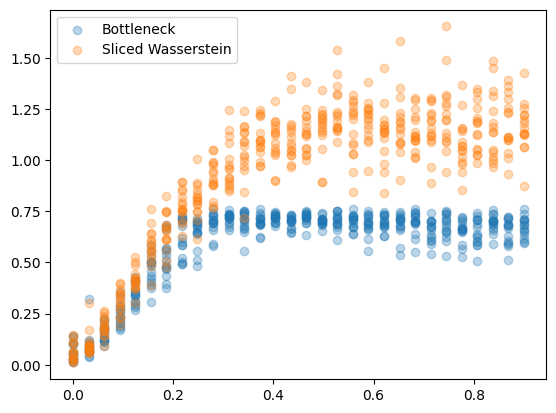

In [19]:
plt.scatter(dists_bottleneck[:,0], dists_bottleneck[:,1], label="Bottleneck", alpha=0.3)
plt.scatter(dists_sliced[:,0], dists_sliced[:,1], label="Sliced Wasserstein", alpha=0.3)
plt.legend()
plt.show()

These results are a little strange at first, but remember the raidus for the circle is only 0.5 by default, so a noise level of 0.6 implies the standard deviation of noise is larger than the radius. The grid of plots below shows the resulting matchings. After a certain level of noise, the two objects are not directly matched any more.

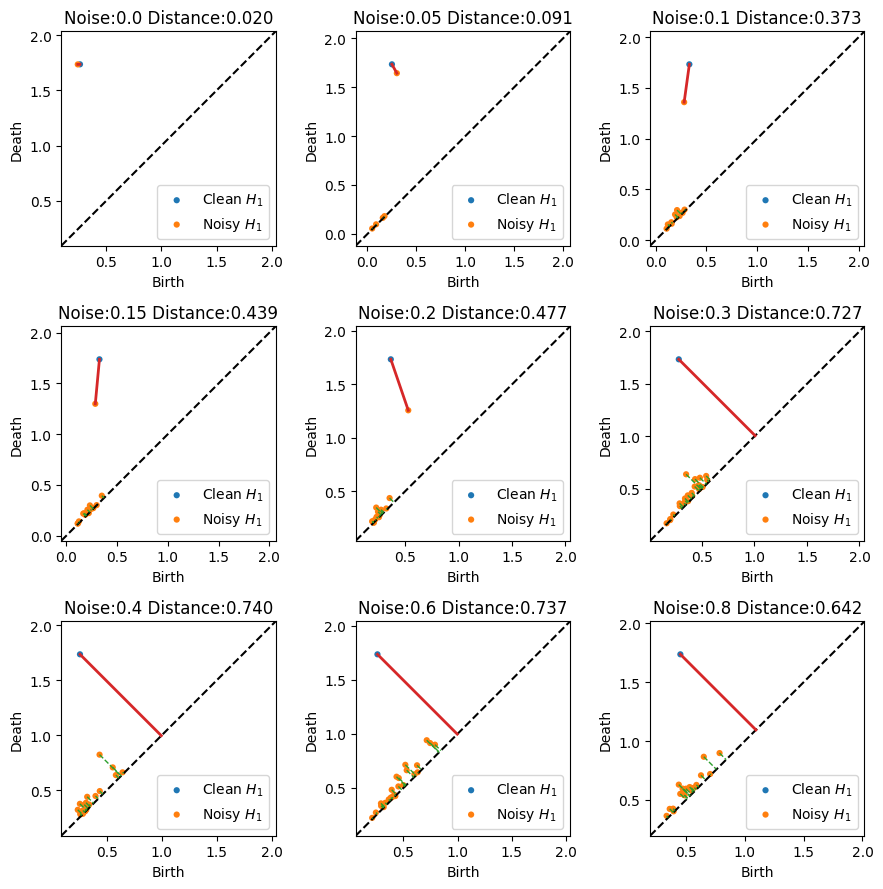

In [20]:
plt.figure(figsize=(9,9))
for i, n in enumerate([0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8]):
    plt.subplot(331+i)

    ds_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
    dgm_clean = ripser.ripser(ds_clean)['dgms'][1]

    ds = tadasets.dsphere(d=1, n=100, noise=n)
    dgm = ripser.ripser(ds)['dgms'][1]

    d, matching = persim.bottleneck(
        dgm_clean,
        dgm,
        matching=True
    )
    
    persim.bottleneck_matching(dgm_clean, dgm, matching, labels=['Clean $H_1$', 'Noisy $H_1$'])

    plt.title("Noise:{} Distance:{:.3f}".format(n, d))

plt.tight_layout()
plt.show()